In [4]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd


## Lets see what we are dealing with

In [5]:
import os

# Base path of the project
BASE_PATH = os.path.dirname(os.path.realpath(__doc__))
# Path of segemented songs
SONG_PATH = os.path.join(BASE_PATH, 'SongCollection\\songs\\segment_30\\')
# Get all names of segmented songs
song_list = os.listdir(SONG_PATH)


In [6]:
# For reproducibility
np.random.seed(0)

# Get a random sample
rndm_song_name = np.random.choice(song_list)

rndm_song_name

'blues_05_The Well.mp3'

The song is of **Blues** genre, **5th** segment and is names **The Well**

In [7]:
rndm_song_path = os.path.join(SONG_PATH,rndm_song_name)

# Listening to the audio
ipd.Audio(rndm_song_path)

In [8]:
# Ignoring warnings given out by librosa for using mp3 file format 
import warnings
warnings.filterwarnings('ignore')


# Getting the digital signal
the_well, sr = librosa.load(rndm_song_path)

sample_duration = 1 / sr

In [9]:
print(f"The signal contains {the_well.shape[0]} sample of signals with sampling rate of {sr}.")
print(f"Duration of 1 sample is {sample_duration:.6f}s")

The signal contains 661504 sample of signals with sampling rate of 22050.
Duration of 1 sample is 0.000045s


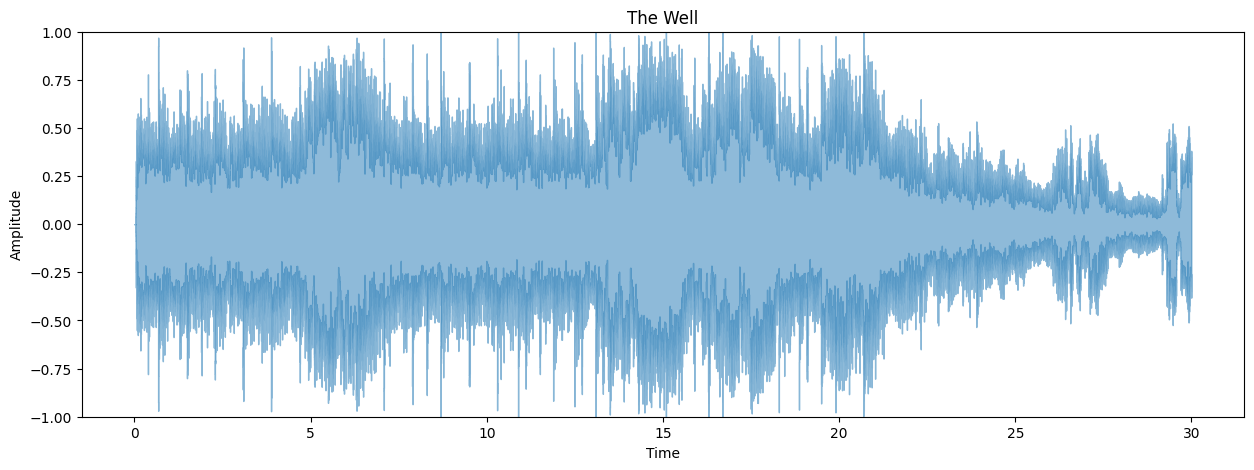

In [10]:
# Visualize the waveform


plt.figure(figsize=(15,5))


librosa.display.waveshow(the_well, alpha=.5)
plt.title("The Well")
plt.ylabel("Amplitude")
plt.ylim((-1, 1))



plt.show()

## Feature Visualization

First, lets look at time domain features.


In [11]:
# Instead of calculating one feature for 30 second of samples.
# We divide the samples into size of FRAME_SIZE
FRAME_SIZE = 1024

# To prevent discontinuity in signals when processing, we use HOP_LENGTH to overlap frames
HOP_LENGTH = 512

### Amplitude Envelope
Maximum aplitude value for all samples in a frame

In [12]:
def amplitude_envelope(signal, frame_size, hop_length):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

am_the_well = amplitude_envelope(the_well, FRAME_SIZE, HOP_LENGTH)

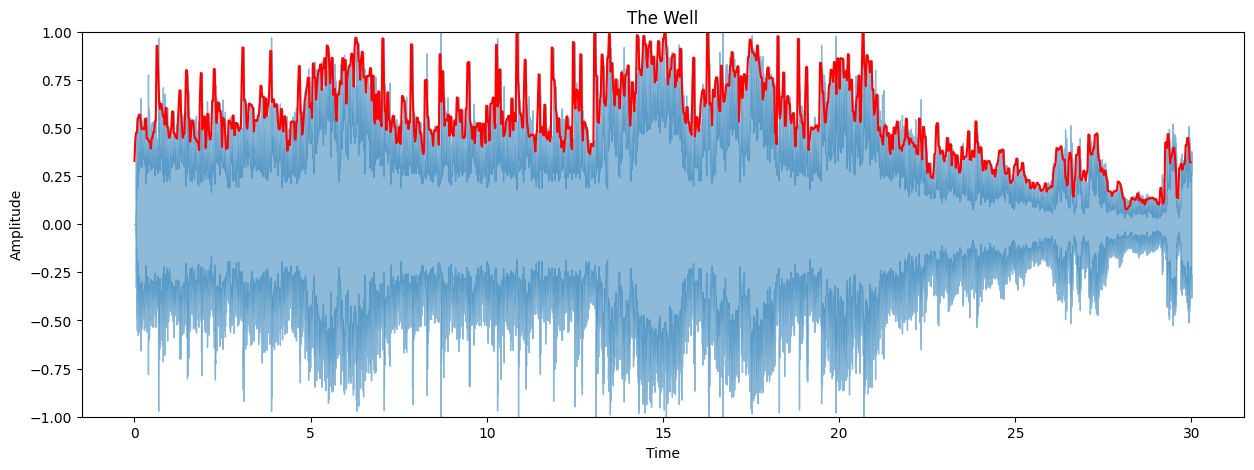

In [13]:
# Visualizing amplitude envelope

frames = range(am_the_well.size)
# Converting to time
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)


plt.figure(figsize=(15,5))
librosa.display.waveshow(the_well, alpha=.5)
plt.plot(t, am_the_well, color="r")
plt.title("The Well")
plt.ylabel("Amplitude")

plt.ylim((-1, 1))


plt.show()

### Root Mean Square Energy
The root mean square of energy of all samples in a frame

In [14]:
rms_the_well = librosa.feature.rms(the_well, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

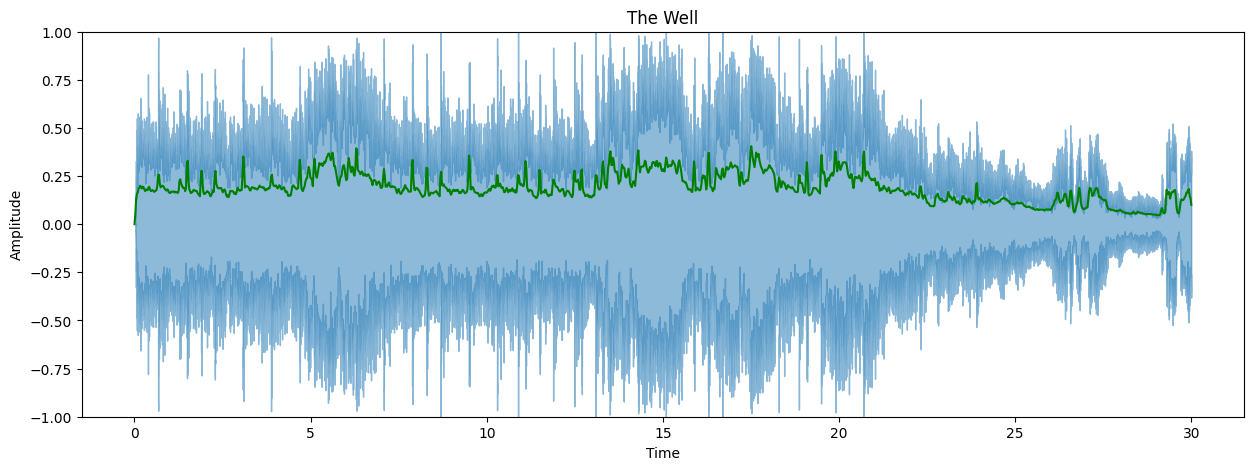

In [15]:
# Visualizing RMSE

frames = range(rms_the_well.size)
# Converting to time
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)


plt.figure(figsize=(15,5))
librosa.display.waveshow(the_well, alpha=.5)
plt.plot(t, rms_the_well, color="g")
plt.title("The Well")
plt.ylabel("Amplitude")

plt.ylim((-1, 1))


plt.show()

### Zero Crossing Rate
Number of times a signal crosses the horizontal axis (y=0)

In [16]:
zcr_the_well = librosa.feature.zero_crossing_rate(the_well, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

(0.0, 0.5)

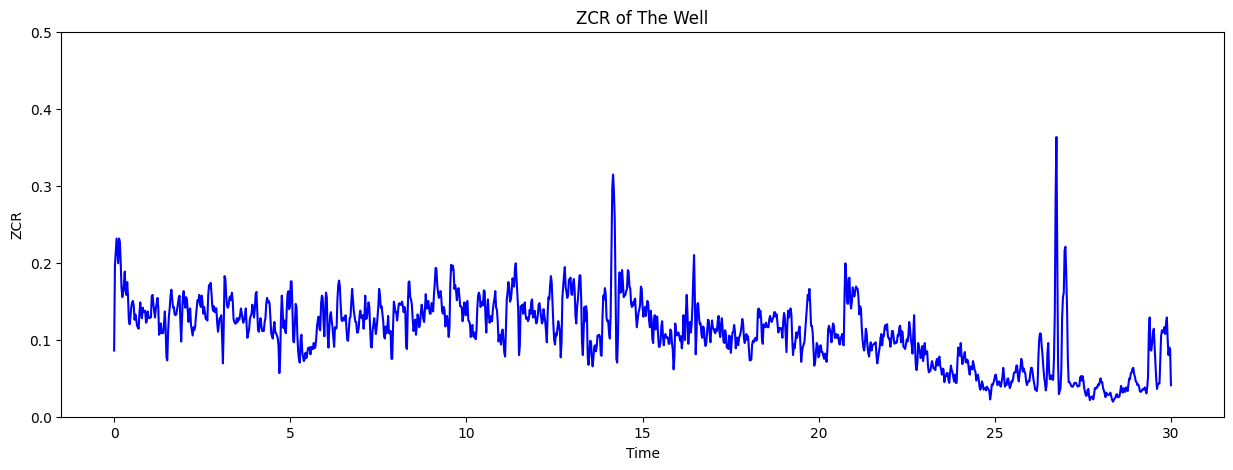

In [17]:
plt.figure(figsize=(15,5))
plt.plot(t, zcr_the_well, color="b",)
plt.title("ZCR of The Well")
plt.xlabel("Time")
plt.ylabel("ZCR")
plt.ylim((0, .5))


To convert the audio signal which is a function of time into a function of frequency and phase, we used Fourier Transform. Fourier Transform compares each signal with multiple sinusoidal waves and returns the one having least difference.

The ouptut of a Fourier transform is an array of complex numbers with real number being the frequency and imaginary part being the phase. We can ignore the frequency to extract features.

In [18]:
the_well_fft = np.fft.fft(the_well)

In [19]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)

    # Plot the magnitude spectrum.
    plt.figure(figsize=(18, 5))

    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    num_frequency_bins = int(len(frequency) * f_ratio)


    plt.plot(frequency[:num_frequency_bins], magnitude_spectrum[:num_frequency_bins])
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")


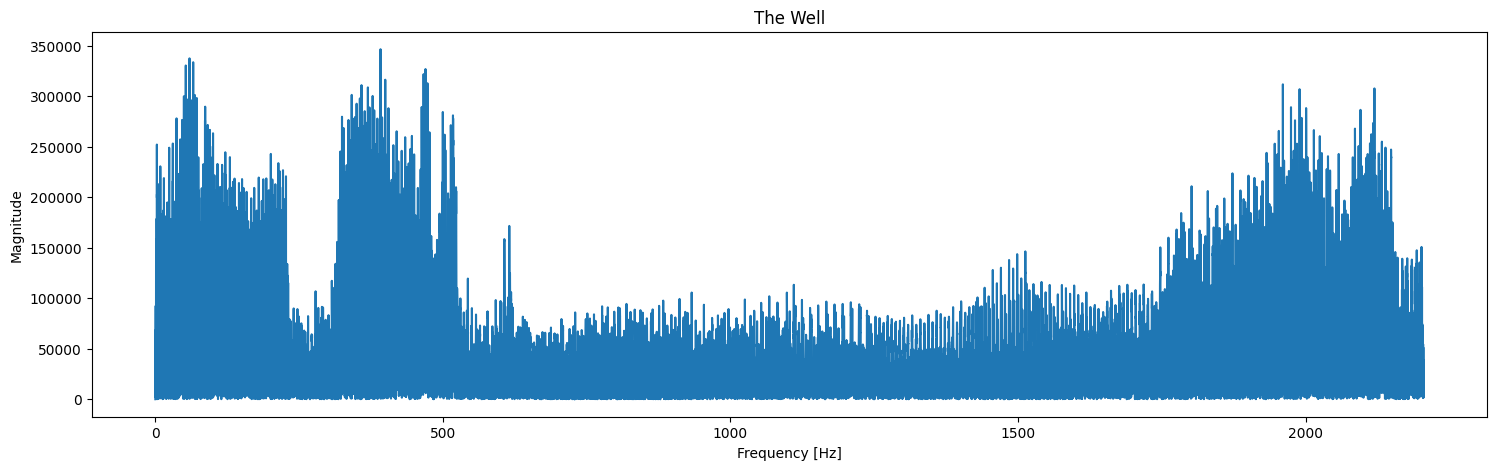

In [20]:
plot_magnitude_spectrum(the_well_fft, "The Well", sr, .1)

This information can be combined with time domain features to extract spectrogram.
Spectrogram is used to extract information visually.

In [21]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25,10))
    librosa.display.specshow(
        Y,
        sr=sr,
        hop_length = hop_length,
        x_axis = "time",
        y_axis = y_axis
    )
    plt.colorbar(format="%+2.f")

In [22]:
the_well_stft = librosa.stft(the_well, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)

the_well_spectrogram = np.abs(the_well_stft) ** 2

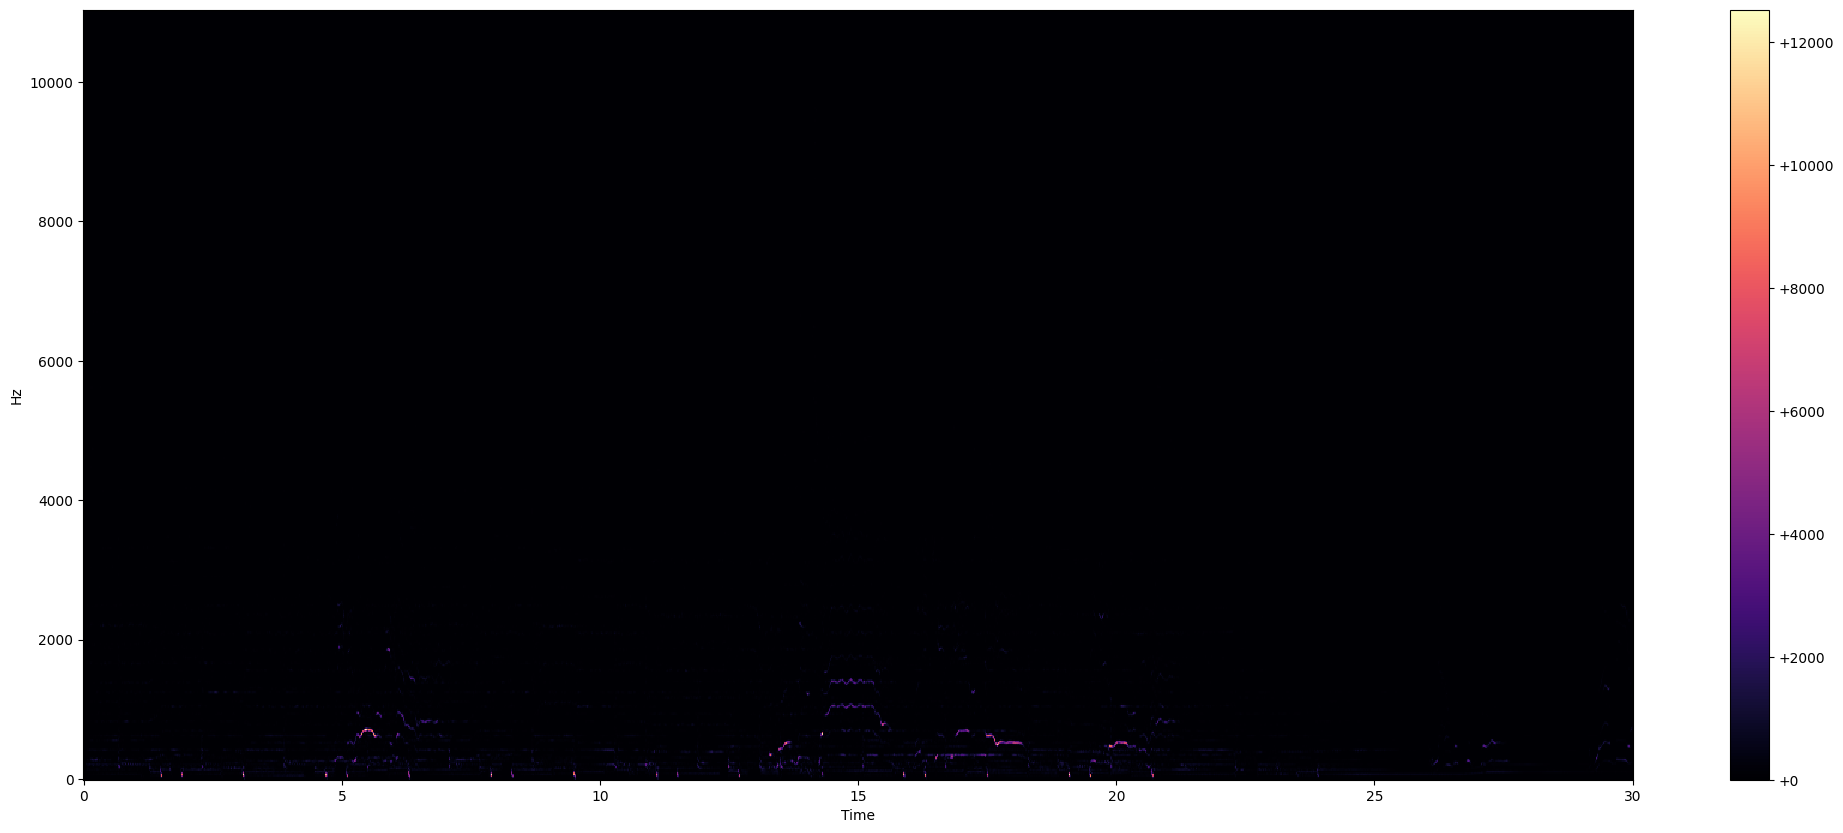

In [23]:
plot_spectrogram(the_well_spectrogram, sr, HOP_LENGTH)

We cannot make much out of this plot because frequency works on lograthimic scale. Meaning frequencies 200Hz and 300Hz sound very different where as frequencies 4000Hz and 4100Hz (same difference) sound very similar.

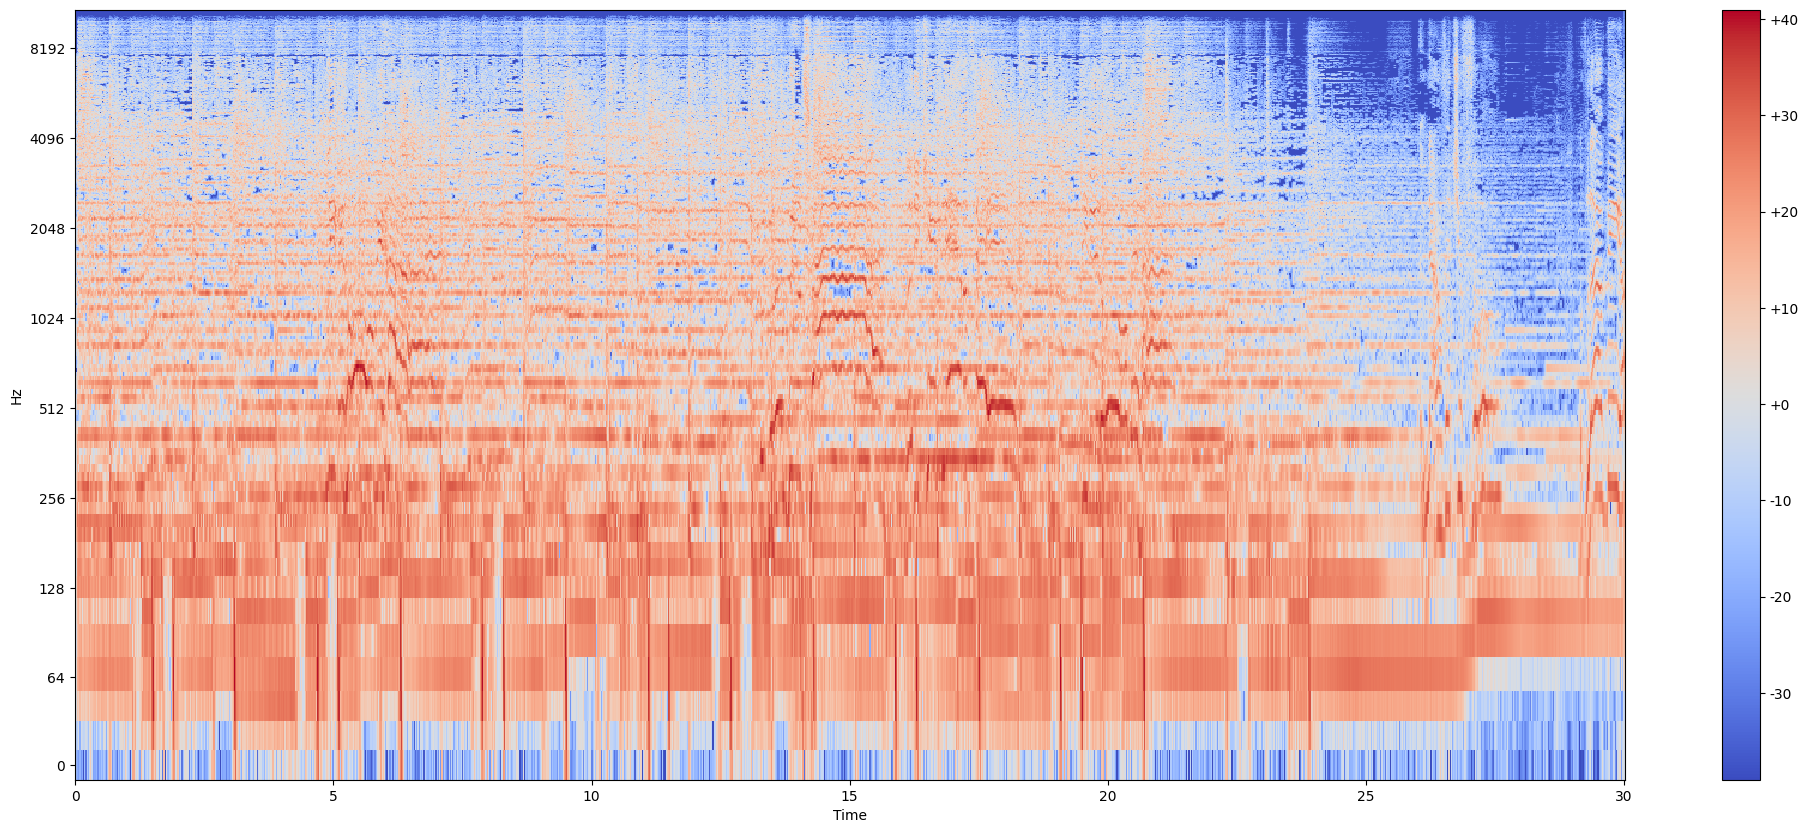

In [24]:
the_well_spectrogram_log = librosa.power_to_db(the_well_spectrogram)
plot_spectrogram(the_well_spectrogram_log, sr, HOP_LENGTH, 'log')

### Band Energy Ratio
Comparison of energy in the lower / higher frequency bands

In [25]:

def calculate_split_frequency_bins(spectrogram, split_frequency, sample_rate):
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / spectrogram.shape[0]
    split_frequency_bin = np.floor(split_frequency / frequency_delta_per_bin)

    return int(split_frequency_bin)



def calculate_band_enery_ratio(spectrogram, split_frequency, sample_rate):
    split_frequency_bin = calculate_split_frequency_bins(the_well_spectrogram, split_frequency, sr)

    # Move to the power spectrogram

    spec_2 = np.square(np.abs(spectrogram))
    spec_2 = spec_2.T

    # Time, Freq
    upper = [np.sum(mag[:split_frequency_bin]) for mag in spec_2]
    lower = [np.sum(mag[split_frequency_bin:]) for mag in spec_2]

    BER = np.divide(upper, lower)
    
    return BER

In [26]:
ber_the_well = calculate_band_enery_ratio(the_well_spectrogram, 2000, sr)

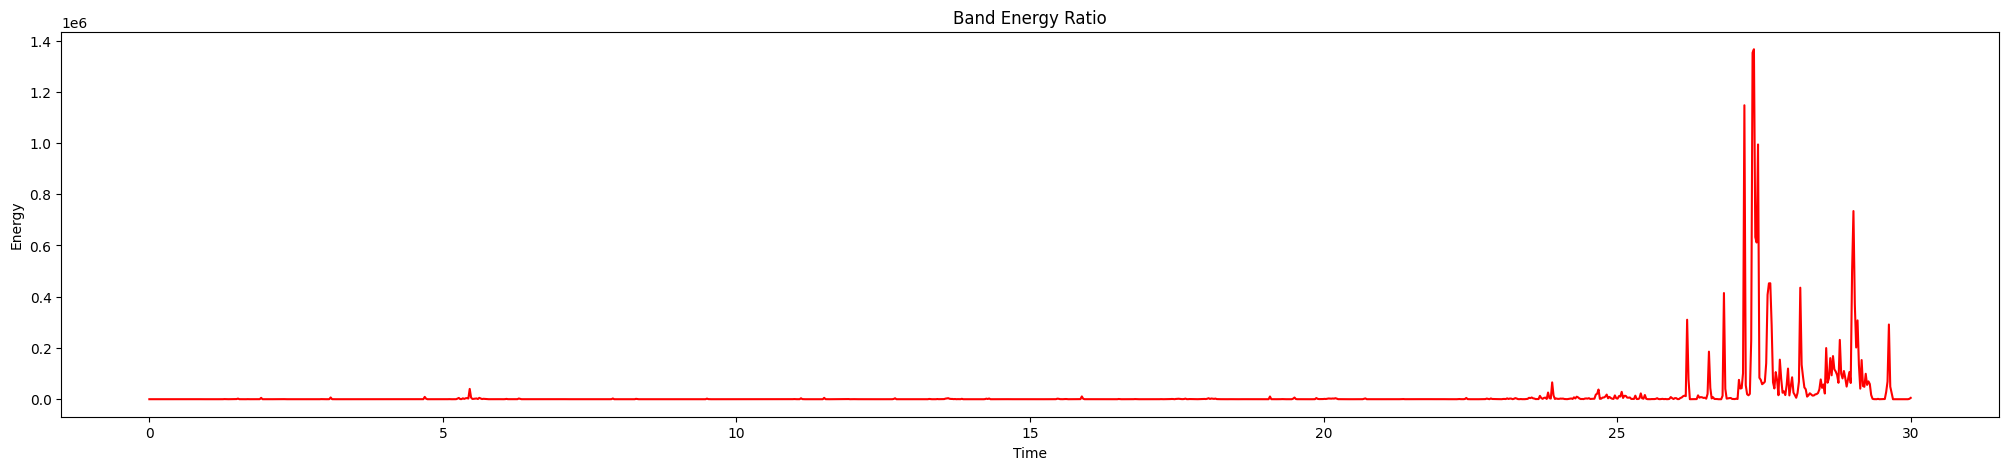

In [27]:
frames = range(len(ber_the_well))

t = librosa.frames_to_time(frames, hop_length = HOP_LENGTH)
plt.figure(figsize=(25,5))
plt.plot(t, ber_the_well, color='r')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Band Energy Ratio")
plt.show()

### Spectral Centroid
Frequency band where most energy is concentrated (center of gravity)

In [28]:
sc_the_well = librosa.feature.spectral_centroid(y=the_well, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]


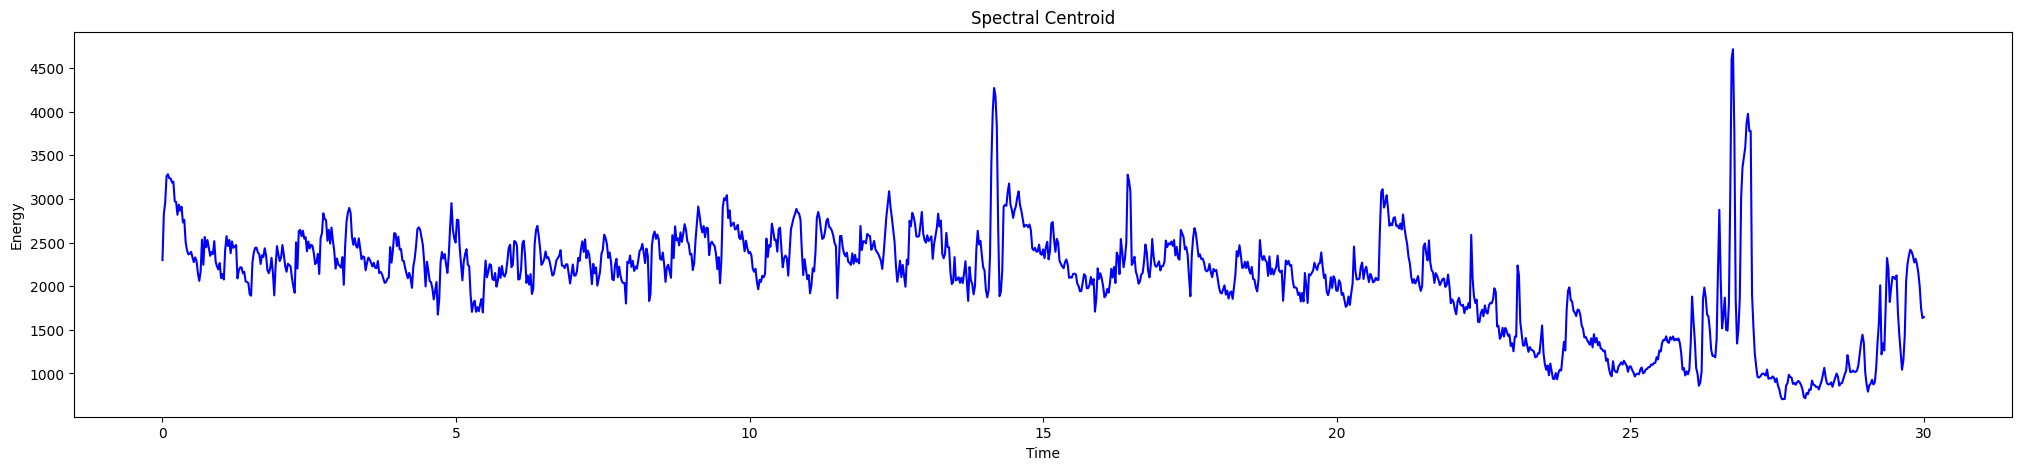

In [29]:
plt.figure(figsize=(25,5))

plt.plot(t, sc_the_well, color='b')
plt.title("Spectral Centroid")
plt.xlabel("Time")
plt.ylabel("Energy")

plt.show()

### Bandwidth
Variance from the spectral centroid

In [30]:
sb_the_well = librosa.feature.spectral_bandwidth(y=the_well, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]


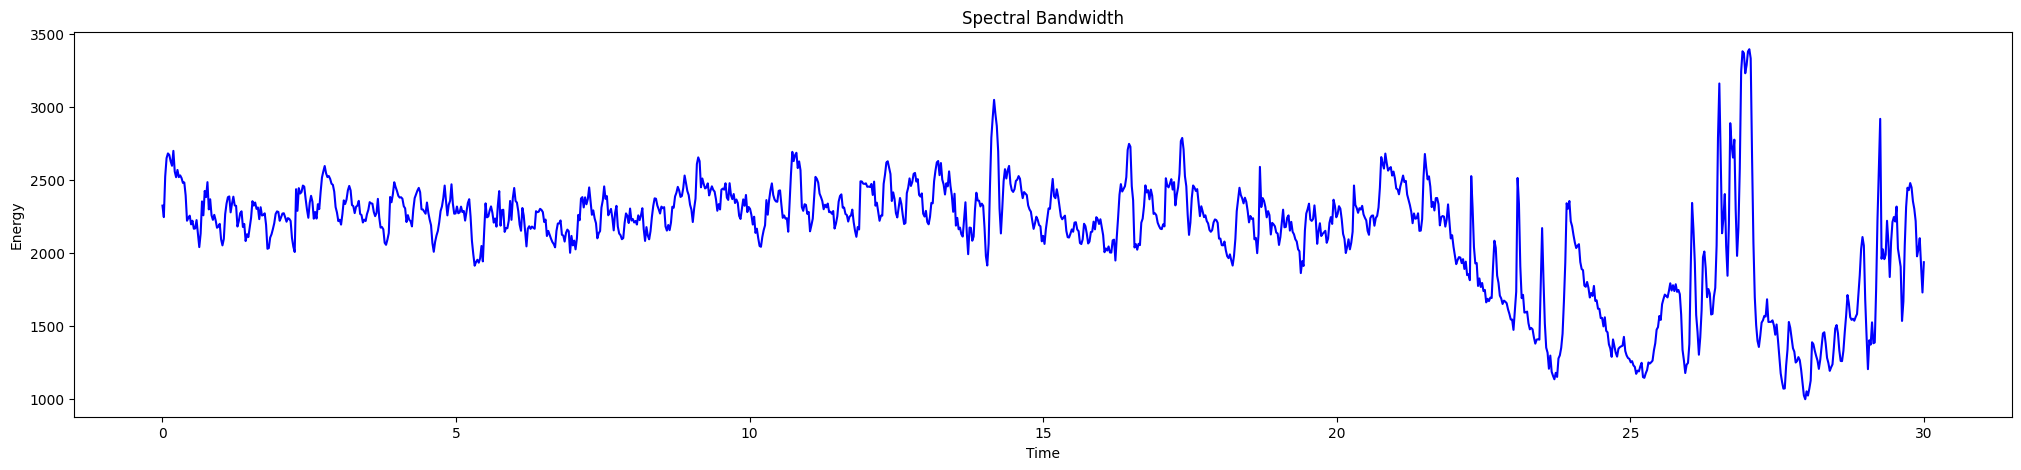

In [31]:
plt.figure(figsize=(25,5))

plt.plot(t, sb_the_well, color='b')
plt.title("Spectral Bandwidth")
plt.xlabel("Time")
plt.ylabel("Energy")

plt.show()

### Mel Frequency Cepstral Coefficients

MFCCs are the coefficients / rhamonics (harmonics) after aplying a Short Time Fourier Transform to a signal, converting to Mel Scale and again applying inverse STFT or Discrete Cosine Transform to obtain cepstrum (spectrum).

In [32]:
mfccs_the_well = librosa.feature.mfcc(the_well, n_mfcc=13, sr=sr)

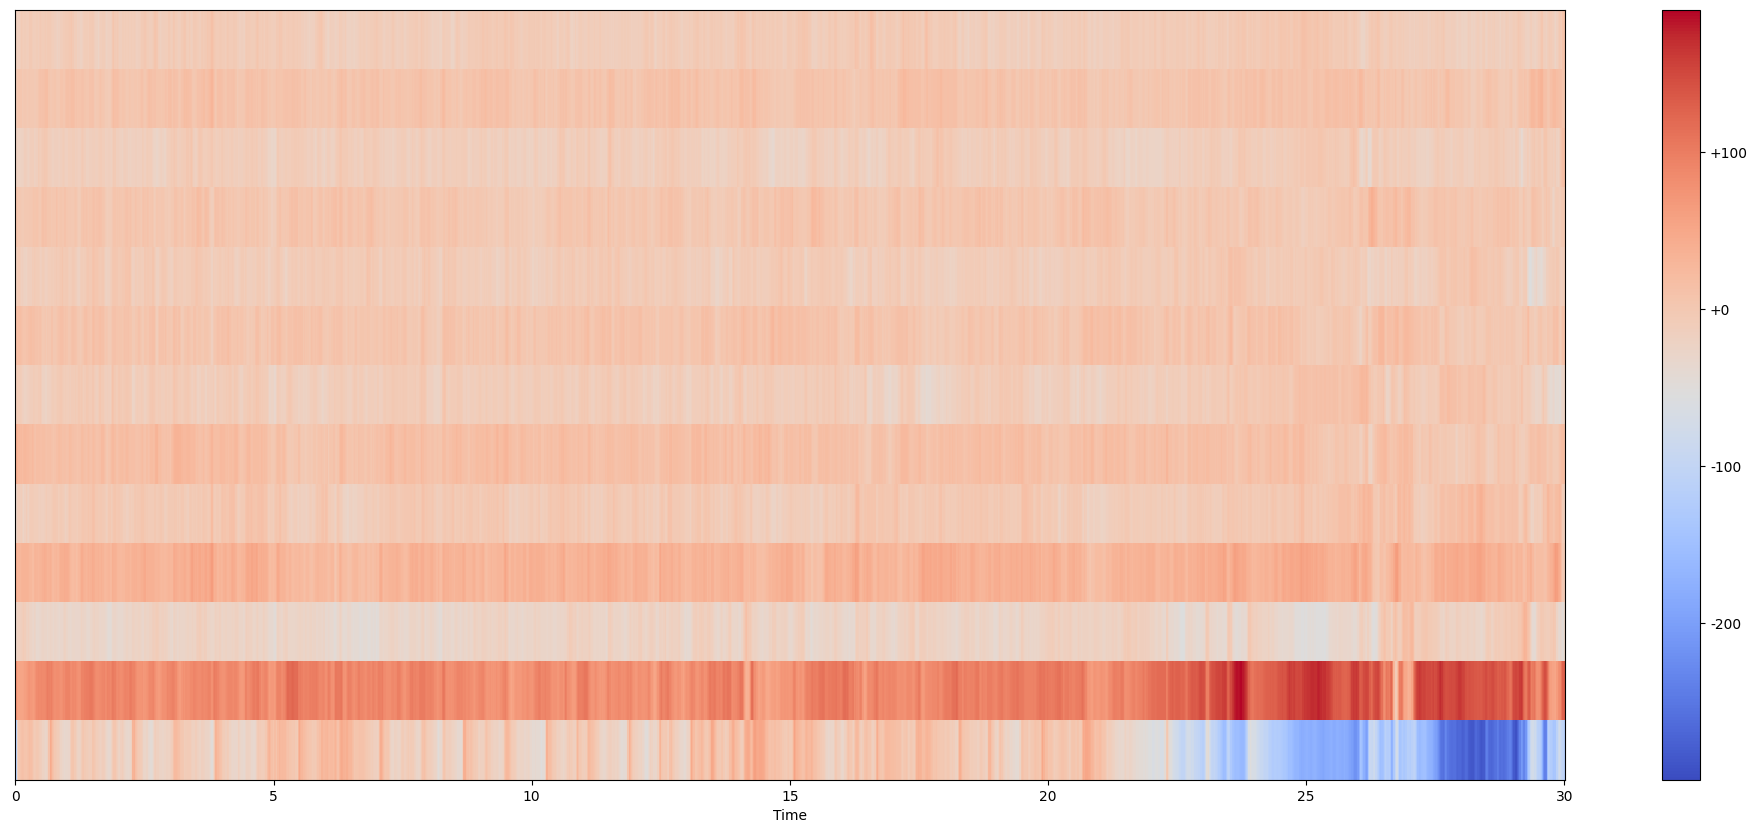

In [33]:
# Visualize MFCCS
plt.figure(figsize=(25,10))
librosa.display.specshow(
    mfccs_the_well,
    sr=sr,
    x_axis="time",

)
plt.colorbar(format="%+2.f")
plt.show()

## Visualizing the data

In [55]:
data = pd.read_csv("data.csv")

In [56]:
data.head()

,Unnamed: 0,Name,Genre,AE_Mean,AE_Std,RMS_Mean,RMS_Std,ZCR_Mean,ZCR_Std,BER_Mean,...,MFCC8_Mean,MFCC8_Std,MFCC9_Mean,MFCC9_Std,MFCC10_Mean,MFCC10_Std,MFCC11_Mean,MFCC11_Std,MFCC12_Mean,MFCC12_Std
0,0,00 Keep Me Around.mp3,blues,0.413604,0.336156,0.209677,0.194919,0.025376,0.029535,NaN,...,0.524046,8.763070,4.678653,10.146228,-0.636792,9.801187,0.803112,8.547368,-1.271596,7.959494
1,1,02 Bring That Fire.mp3,blues,0.718112,0.168150,0.255997,0.080424,0.112043,0.059497,38.635887,...,-8.507063,8.077289,16.341509,7.302747,-3.145405,7.970468,10.843008,7.164038,-1.324588,7.707904
2,2,02 Brown Skin Girl.mp3,blues,0.616966,0.254200,0.253166,0.139158,0.068955,0.067955,290.161600,...,-3.386870,13.729053,16.733223,12.982227,-2.605393,11.408111,13.568317,10.142110,-0.078747,9.629934
3,3,02 Built By Nations.mp3,blues,0.468483,0.090312,0.188463,0.057775,0.100229,0.033683,22.235285,...,-2.887919,7.030292,9.343019,7.367812,-3.488164,6.622704,6.762663,7.461549,-8.813975,8.551544
4,4,02 Broken Boy.mp3,blues,0.836942,0.138522,0.351950,0.102473,0.094648,0.047091,55.915676,...,0.439476,7.986229,11.720238,7.580385,-6.271585,7.267283,8.465326,6.732004,-6.825080,5.850800


In [57]:
data.drop(["Unnamed: 0", "Name"], axis=1, inplace=True)
data.head()

,Genre,AE_Mean,AE_Std,RMS_Mean,RMS_Std,ZCR_Mean,ZCR_Std,BER_Mean,BER_Std,SC_Mean,...,MFCC8_Mean,MFCC8_Std,MFCC9_Mean,MFCC9_Std,MFCC10_Mean,MFCC10_Std,MFCC11_Mean,MFCC11_Std,MFCC12_Mean,MFCC12_Std
0,blues,0.413604,0.336156,0.209677,0.194919,0.025376,0.029535,NaN,NaN,711.632055,...,0.524046,8.763070,4.678653,10.146228,-0.636792,9.801187,0.803112,8.547368,-1.271596,7.959494
1,blues,0.718112,0.168150,0.255997,0.080424,0.112043,0.059497,38.635887,266.052500,2436.861116,...,-8.507063,8.077289,16.341509,7.302747,-3.145405,7.970468,10.843008,7.164038,-1.324588,7.707904
2,blues,0.616966,0.254200,0.253166,0.139158,0.068955,0.067955,290.161600,1790.432100,1931.964510,...,-3.386870,13.729053,16.733223,12.982227,-2.605393,11.408111,13.568317,10.142110,-0.078747,9.629934
3,blues,0.468483,0.090312,0.188463,0.057775,0.100229,0.033683,22.235285,32.812187,2083.294767,...,-2.887919,7.030292,9.343019,7.367812,-3.488164,6.622704,6.762663,7.461549,-8.813975,8.551544
4,blues,0.836942,0.138522,0.351950,0.102473,0.094648,0.047091,55.915676,221.270840,2311.364885,...,0.439476,7.986229,11.720238,7.580385,-6.271585,7.267283,8.465326,6.732004,-6.825080,5.850800


In [58]:
data.describe()

,AE_Mean,AE_Std,RMS_Mean,RMS_Std,ZCR_Mean,ZCR_Std,BER_Mean,BER_Std,SC_Mean,SC_Std,...,MFCC8_Mean,MFCC8_Std,MFCC9_Mean,MFCC9_Std,MFCC10_Mean,MFCC10_Std,MFCC11_Mean,MFCC11_Std,MFCC12_Mean,MFCC12_Std
count,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,1.938300e+04,1.938300e+04,27501.000000,27501.000000,...,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000,27501.000000
mean,0.497027,0.181176,0.194156,0.085674,0.089451,0.055508,1.355724e+27,inf,1914.208916,735.508070,...,-6.793407,10.238448,7.685111,9.826224,-6.151084,9.254481,5.516806,8.800515,-5.717512,8.590674
std,0.229019,0.074813,0.094700,0.040884,0.035390,0.025902,1.305061e+29,NaN,553.209376,274.971078,...,6.580735,2.931959,6.403885,2.666399,5.577384,2.480796,5.421237,2.251107,4.731295,2.176654
min,-0.000437,0.000000,0.000000,0.000000,0.000000,0.000000,7.349587e-02,5.994551e-02,0.000000,0.000000,...,-48.111794,0.000000,-35.094646,0.000000,-35.934734,0.000000,-31.177902,0.000000,-40.247192,0.000000
25%,0.327570,0.131121,0.122370,0.057129,0.066353,0.038373,2.562871e+01,4.029226e+01,1572.463417,554.225024,...,-10.353065,8.226035,4.222171,8.001241,-9.345098,7.551906,2.599039,7.294086,-8.488600,7.129545
50%,0.521295,0.182465,0.200132,0.082460,0.086606,0.051144,7.803704e+01,1.815349e+02,1942.251855,715.709600,...,-6.265254,9.937851,8.461375,9.625252,-5.862081,9.054933,6.227400,8.637455,-5.727238,8.466826
75%,0.683220,0.230615,0.267320,0.113337,0.109571,0.067607,2.999927e+02,9.707720e+02,2286.566287,886.814209,...,-2.511854,11.997938,11.937708,11.462139,-2.705712,10.785304,9.170105,10.164124,-2.827818,9.885674
max,1.033104,0.489485,0.643854,0.277205,0.642743,0.326102,1.714600e+31,inf,7140.231790,3074.685389,...,30.514725,27.343313,30.513494,31.634895,27.458527,30.226973,36.778534,29.764890,17.423120,24.876154


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27501 entries, 0 to 27500
Data columns (total 39 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Genre        27501 non-null  object 
 1   AE_Mean      27501 non-null  float64
 2   AE_Std       27501 non-null  float64
 3   RMS_Mean     27501 non-null  float64
 4   RMS_Std      27501 non-null  float64
 5   ZCR_Mean     27501 non-null  float64
 6   ZCR_Std      27501 non-null  float64
 7   BER_Mean     19383 non-null  float64
 8   BER_Std      19383 non-null  float64
 9   SC_Mean      27501 non-null  float64
 10  SC_Std       27501 non-null  float64
 11  BW_Mean      27501 non-null  float64
 12  BW_Std       27501 non-null  float64
 13  MFCC0_Mean   27501 non-null  float64
 14  MFCC0_Std    27501 non-null  float64
 15  MFCC1_Mean   27501 non-null  float64
 16  MFCC1_Std    27501 non-null  float64
 17  MFCC2_Mean   27501 non-null  float64
 18  MFCC2_Std    27501 non-null  float64
 19  MFCC

The BER has a lot of null values caused because of division by 0.

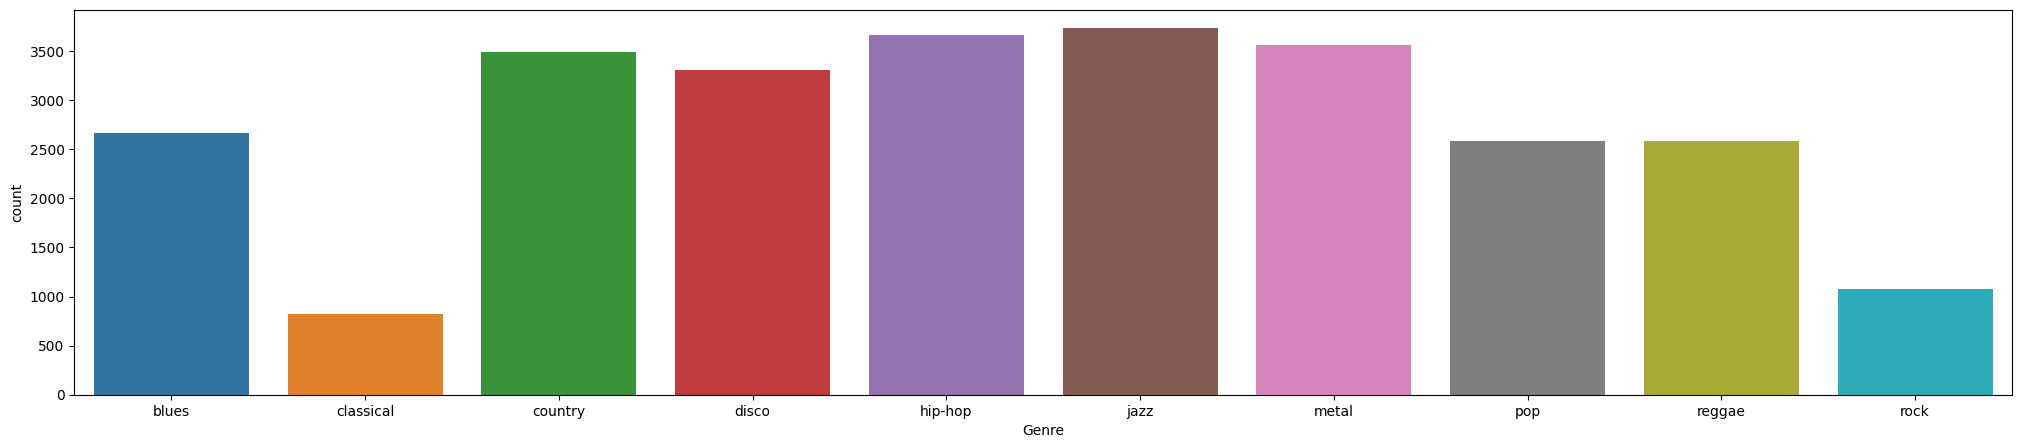

In [60]:
plt.figure(figsize=(25,5))
sns.countplot(data=data, x="Genre");

The data contains very less samples of **classical** and **rock** songs. So oversampling / undersampling might be required.

In [61]:

# Label encoding the output
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Genre'] = le.fit_transform(data['Genre'])


In [62]:
corr = data.corr()
corr.shape

(39, 39)

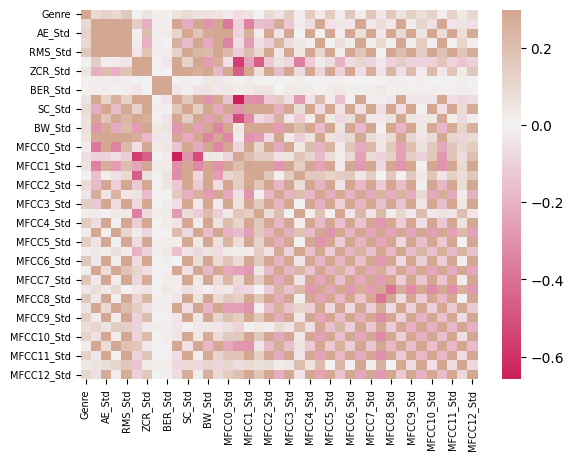

In [63]:
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(corr, vmax=.3, cmap=cmap, center=0,)
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7);

In [64]:
# Removing null and inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)


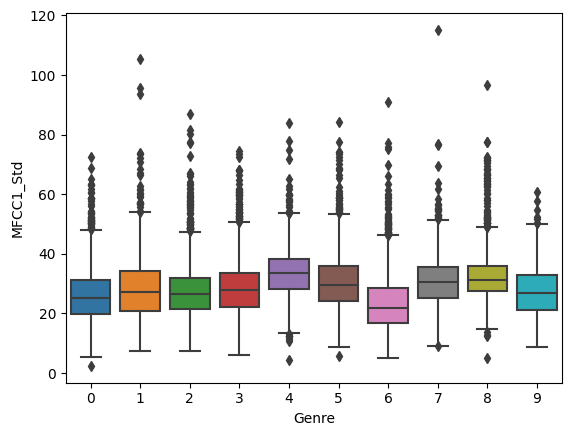

In [65]:
sns.boxplot(data=data, y="MFCC1_Std", x="Genre");

In [66]:
from numpy import percentile

def remove_outliers(df, col_name):
    q25, q75 = percentile(df[col_name], 25), percentile(df[col_name], 75)
    iqr = q75 - q25

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    return df[(df[col_name] > lower) & (df[col_name] < upper)]

In [67]:
data_new = data.copy()
print(f"Before outliers removal: Size = {data_new.shape[0]}")

for col_name in data_new.drop('Genre',axis=1).columns:
    data_new = remove_outliers(data_new, col_name)
    
print(f"After outliers removal: Size = {data_new.shape[0]}")    

Before outliers removal: Size = 19378
After outliers removal: Size = 9350


More than 10,000 data were removed as outiers. The loss of information from this removal seems more than the advantage of removing the outliers.

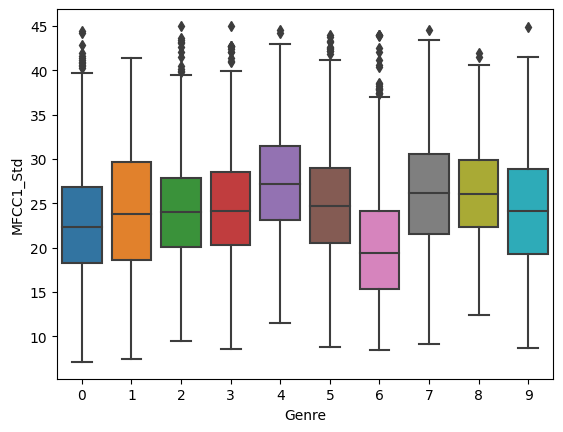

In [71]:
sns.boxplot(data=data_new, y="MFCC1_Std", x="Genre");

In [72]:
# Reducing dimensions to see distribution of genre in 2D space
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Normalizing the data first to prevent larger variances dominating lesser 
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data.drop("Genre", axis=1)), columns=data.drop("Genre",axis=1).columns)

pca = PCA(n_components=2)
data_pca = pd.DataFrame(pca.fit_transform(scaled_data), columns=["PC1", "PC2"])

data_pca['Genre'] = data['Genre']


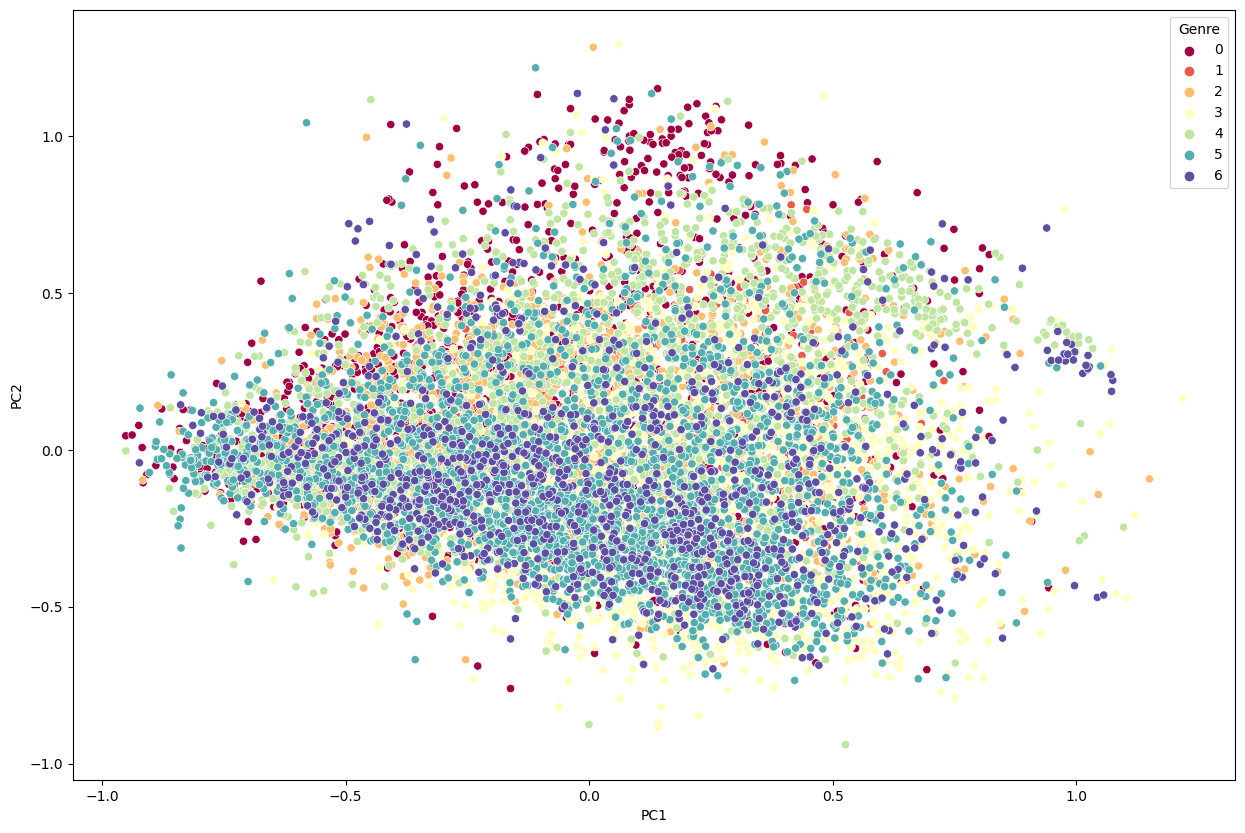

In [73]:
palette = sns.color_palette("Spectral", as_cmap=True)
plt.figure(figsize=(15,10))
sns.scatterplot(x = "PC1", y = "PC2", data = data_pca, hue="Genre", palette=palette);
